
<img src="fga.png" width="1200" height="400">


<h1>Aula Extra 5 - Random Forest aplicado em Algo trading</h1>

A presente aula aborda técnicas de classificação denominadas de decision tree e randon forest. Nesse sentido, esses modelos de Machine Learning para classificação foram treinados para incorporar regras de algotrading, baseada em crossover dos eventos de sucesso, buscando "melhorar" o desempenho operacional do cruzamento de médias.


<ul>
    <li> <b>Universidade de Brasília - UnB</b> </li>
    <li> <b>Campus UnB Gama</b> </li>
    <li> <b>Disciplina: Processamento Digital de Sinais Financeiros</b> </li>
    <a href="https://www.linkedin.com/in/marcelino-andrade-b164b369/">
    <li> <b>Prof. Marcelino Monteiro de Andrade Dr.</b> </li>
</ul>


<b> Bibliotecas de Refência</b>

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import investpy

## 1) Leitura e Validação de preços


In [2]:
stocks=['PETR4','VALE3']
n=1
data = investpy.get_stock_historical_data(stock=stocks[n],
                                        country='Brazil',
                                        from_date='01/01/2000',
                                        to_date='29/09/2020')

,Close,Currency,High,Low,Open,Volume
Date,,,,,,
2000-12-17,2.60,BRL,2.60,2.54,2.60,184320
2000-12-18,2.63,BRL,2.63,2.59,2.61,576001
2000-12-19,2.57,BRL,2.57,2.57,2.57,298800
2000-12-20,2.57,BRL,2.58,2.57,2.57,461880
2000-12-21,2.63,BRL,2.63,2.57,2.57,273600


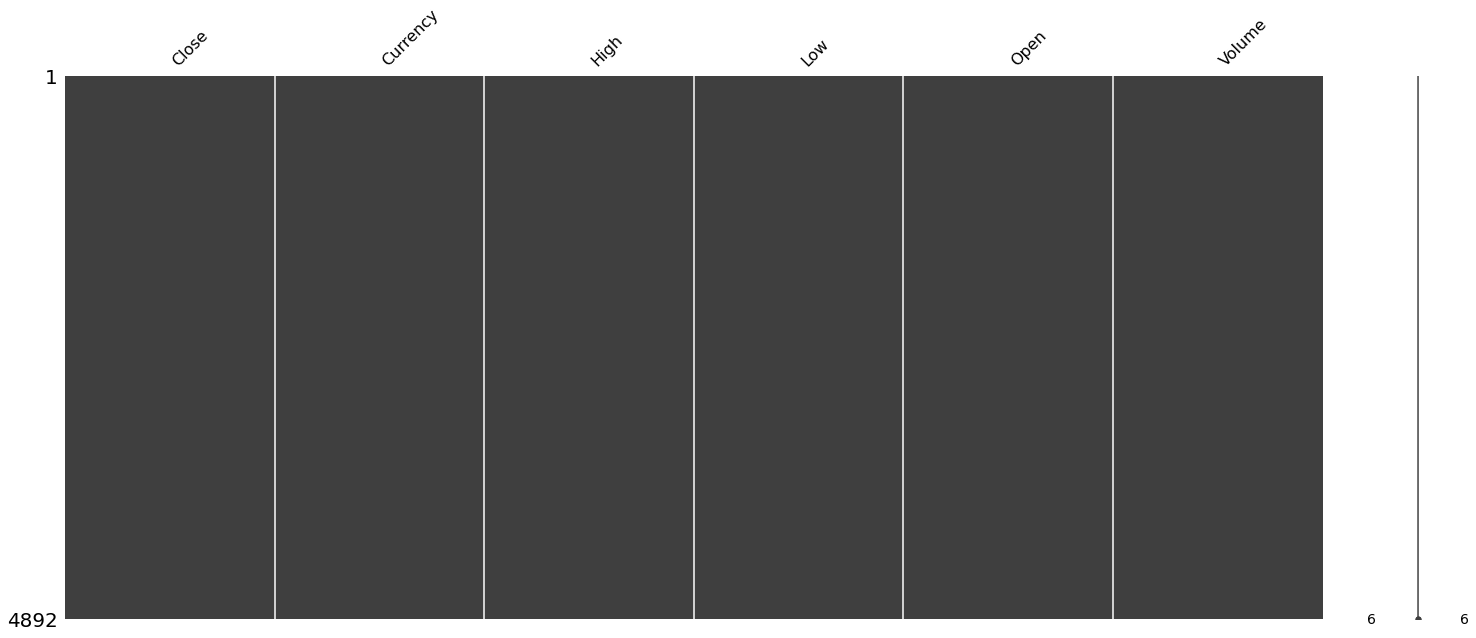

In [3]:
import missingno as msno
msno.matrix(data)
data.head()

Text(0.5, 1.0, 'VALE3')

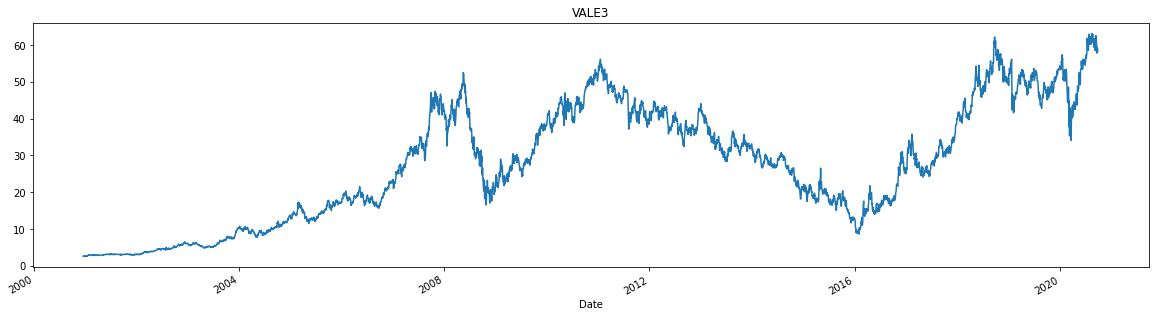

In [4]:
data["Close"].plot(figsize=(20,5))
plt.title(stocks[n])

## 2) Indicadores Técnicos


In [5]:
def average_true_range(data, trend_periods=14, open_col='open', high_col='high', low_col='low', close_col='close', drop_tr = True):
    for index, row in data.iterrows():
        prices = [row[high_col], row[low_col], row[close_col], row[open_col]]
        if index > 0:
            val1 = np.amax(prices) - np.amin(prices)
            val2 = abs(np.amax(prices) - data.at[index - 1, close_col])
            val3 = abs(np.amin(prices) - data.at[index - 1, close_col])
            true_range = np.amax([val1, val2, val3])

        else:
            true_range = np.amax(prices) - np.amin(prices)

        data.set_value(index, 'true_range', true_range)
    data['atr'] = data['true_range'].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    if drop_tr:
        data = data.drop(['true_range'], axis=1)
        
    return data

def rsi(data, periods=14, close_col='close'):
    data['rsi_u'] = 0.
    data['rsi_d'] = 0.
    data['rsi'] = 0.
    
    for index,row in data.iterrows():
        if index >= periods:
            
            prev_close = data.at[index-periods, close_col]
            if prev_close < row[close_col]:
                data.set_value(index, 'rsi_u', row[close_col] - prev_close)
            elif prev_close > row[close_col]:
                data.set_value(index, 'rsi_d', prev_close - row[close_col])
            
    data['rsi'] = data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() / (data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() 
                                                                                                        + data['rsi_d'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean())
    
    data = data.drop(['rsi_u', 'rsi_d'], axis=1)
        
    return data

## 3) Geração da Base de Dados

In [6]:
short_window = 3
long_window = 9

# Inicia sinal DataFrame
signals = pd.DataFrame(index=data.index)
signals['signal_buy'] = 0.0
signals['desvio'] = 0.0
signals['close'] = data['Close'].astype(float) 
signals['high'] = data['High'].astype(float) 
signals['low'] = data['Low'].astype(float) 
signals['open'] = data['Open'].astype(float) 
signals['volume'] = data['Volume'].astype(float) 
signals['desvio'] = signals['close'].rolling(window=short_window).std()

# Média Rápida
signals['short_mavg'] = data['Close'].rolling(window=short_window).mean()

# Média Longa
signals['long_mavg'] = data['Close'].rolling(window=long_window).mean()

# Sinal de Entrada
signals['signal_buy'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                          - signals['long_mavg'][short_window:] > 0, 1.0, 0.0)  

signals['cross']=signals['short_mavg']-signals['long_mavg']
signals=signals.reset_index()
average_true_range(signals)
rsi(signals)
signals=signals.set_index("Date")

#signals['cross']=signals['cross']#/np.max([np.max(signals['cross']),-np.min(signals['cross'])])
display(signals.head(11))
signals.dropna(inplace=True)
display(signals.head())

,signal_buy,desvio,close,high,low,open,volume,short_mavg,long_mavg,cross,true_range,atr,rsi_u,rsi_d,rsi
Date,,,,,,,,,,,,,,,
2000-12-17,0.0,NaN,2.60,2.60,2.54,2.60,184320.0,NaN,NaN,NaN,0.06,0.060000,0.0,0.0,NaN
2000-12-18,0.0,NaN,2.63,2.63,2.59,2.61,576001.0,NaN,NaN,NaN,0.04,0.049655,0.0,0.0,NaN
2000-12-19,0.0,0.030000,2.57,2.57,2.57,2.57,298800.0,2.600000,NaN,NaN,0.06,0.053344,0.0,0.0,NaN
2000-12-20,0.0,0.034641,2.57,2.58,2.57,2.57,461880.0,2.590000,NaN,NaN,0.01,0.041362,0.0,0.0,NaN
2000-12-21,0.0,0.034641,2.63,2.63,2.57,2.57,273600.0,2.590000,NaN,NaN,0.06,0.045621,0.0,0.0,NaN
2000-12-25,0.0,0.034641,2.63,2.69,2.63,2.69,239832.0,2.610000,NaN,NaN,0.06,0.048449,0.0,0.0,NaN
2000-12-26,0.0,0.069282,2.75,2.75,2.63,2.63,308880.0,2.670000,NaN,NaN,0.12,0.060902,0.0,0.0,NaN
2000-12-27,0.0,0.079373,2.78,2.78,2.75,2.75,133200.0,2.720000,NaN,NaN,0.03,0.056045,0.0,0.0,NaN
2001-01-01,1.0,0.107858,2.58,2.58,2.58,2.58,97200.0,2.703333,2.637778,0.065556,0.20,0.076793,0.0,0.0,NaN


,signal_buy,desvio,close,high,low,open,volume,short_mavg,long_mavg,cross,true_range,atr,rsi_u,rsi_d,rsi
Date,,,,,,,,,,,,,,,
2001-01-09,0.0,0.017321,2.63,2.63,2.60,2.63,1571402.0,2.620000,2.667778,-0.047778,0.03,0.074405,0.03,0.00,1.000000
2001-01-10,0.0,0.023094,2.59,2.63,2.58,2.63,157608.0,2.616667,2.650000,-0.033333,0.05,0.071971,0.00,0.04,0.411765
2001-01-11,0.0,0.030551,2.57,2.66,2.57,2.66,77364.0,2.596667,2.626667,-0.030000,0.09,0.073712,0.00,0.00,0.411765
2001-01-14,0.0,0.015275,2.60,2.63,2.60,2.60,10800.0,2.586667,2.628889,-0.042222,0.06,0.072426,0.03,0.00,0.609523
2001-01-15,0.0,0.017321,2.57,2.57,2.57,2.57,3600.0,2.580000,2.608889,-0.028889,0.03,0.068554,0.00,0.06,0.354290


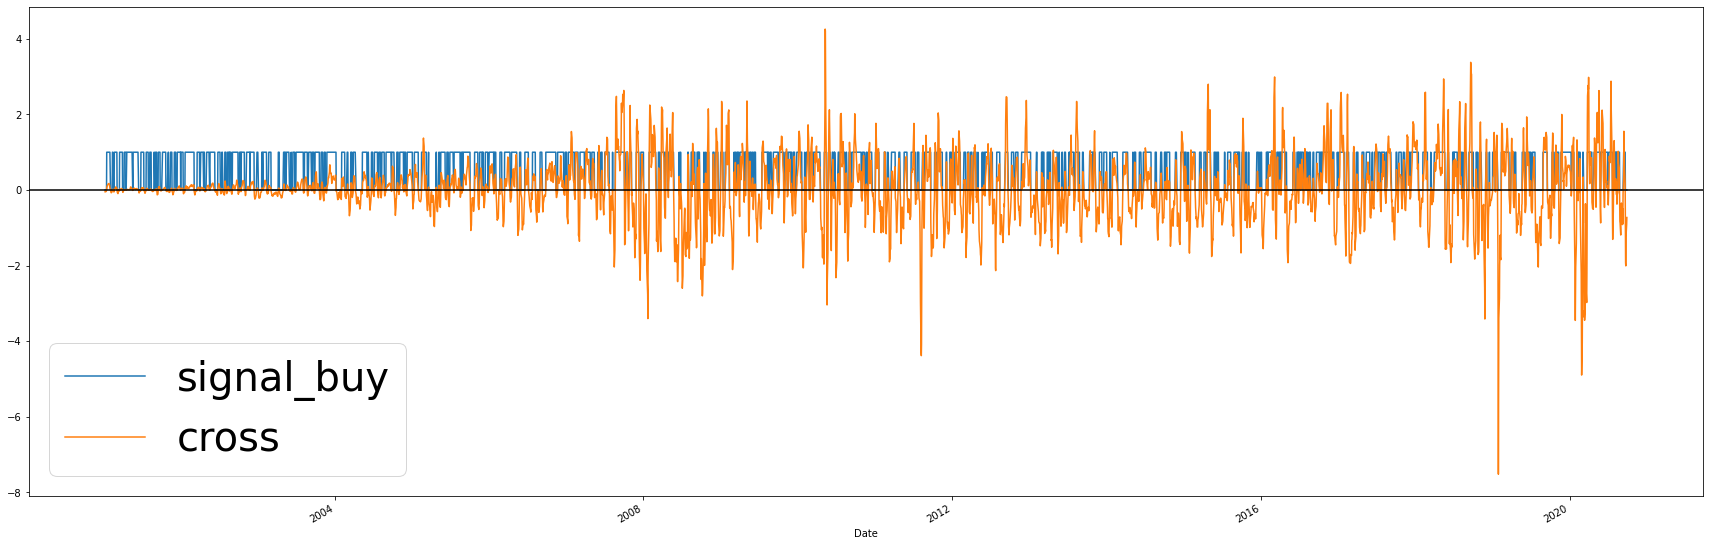

In [7]:
fig, ax = plt.subplots(figsize=(30,10))
#signals[['signal_buy','cross']].iloc[-100:].plot(ax=ax)
signals[['signal_buy','cross']].plot(ax=ax)

ax.axhline(y=0, color='k')
plt.legend(loc=0,prop={'size':40})
#plt.plot(signals[['cross']],"o")

## 4) Identificação dos Trades de Crossover e Volume

In [8]:
buy_closebuy=signals["close"][signals['signal_buy'].diff()==1].values
buy_closesell=signals["close"][signals['signal_buy'].diff()==-1].values
gains=np.array([(buy_closesell[i]-buy_closebuy[i]) for i in range(len(buy_closebuy)-1)])
gains

array([ 1.400e-01, -1.200e-01, -2.100e-01, -1.500e-01,  0.000e+00,
        1.100e-01,  5.000e-02, -6.000e-02,  8.000e-02, -6.000e-02,
       -6.000e-02, -1.100e-01, -4.000e-02,  9.000e-02, -1.300e-01,
       -2.200e-01, -2.000e-02,  2.000e-02, -1.500e-01,  4.500e-01,
       -2.000e-02,  1.500e-01, -1.300e-01,  1.400e-01,  3.300e-01,
       -1.000e-01, -1.900e-01, -4.500e-01,  5.000e-02, -1.700e-01,
        3.700e-01, -1.000e-01,  3.500e-01,  1.700e-01,  4.000e-01,
       -3.000e-01, -9.000e-02,  3.100e-01, -1.500e-01, -2.400e-01,
       -5.000e-02,  0.000e+00,  9.000e-02, -3.000e-02, -1.500e-01,
        7.100e-01,  1.800e-01, -8.000e-02, -2.700e-01,  2.900e-01,
       -4.000e-01, -2.800e-01,  2.860e+00, -3.700e-01, -5.000e-01,
       -4.600e-01, -2.000e-02,  8.900e-01, -4.000e-01, -2.100e-01,
        4.000e-01, -2.700e-01,  3.000e-02,  4.000e-01,  2.800e-01,
       -1.100e-01,  2.800e-01, -1.800e-01,  6.400e-01,  8.300e-01,
        2.210e+00, -7.000e-02, -9.200e-01, -1.060e+00, -1.400e

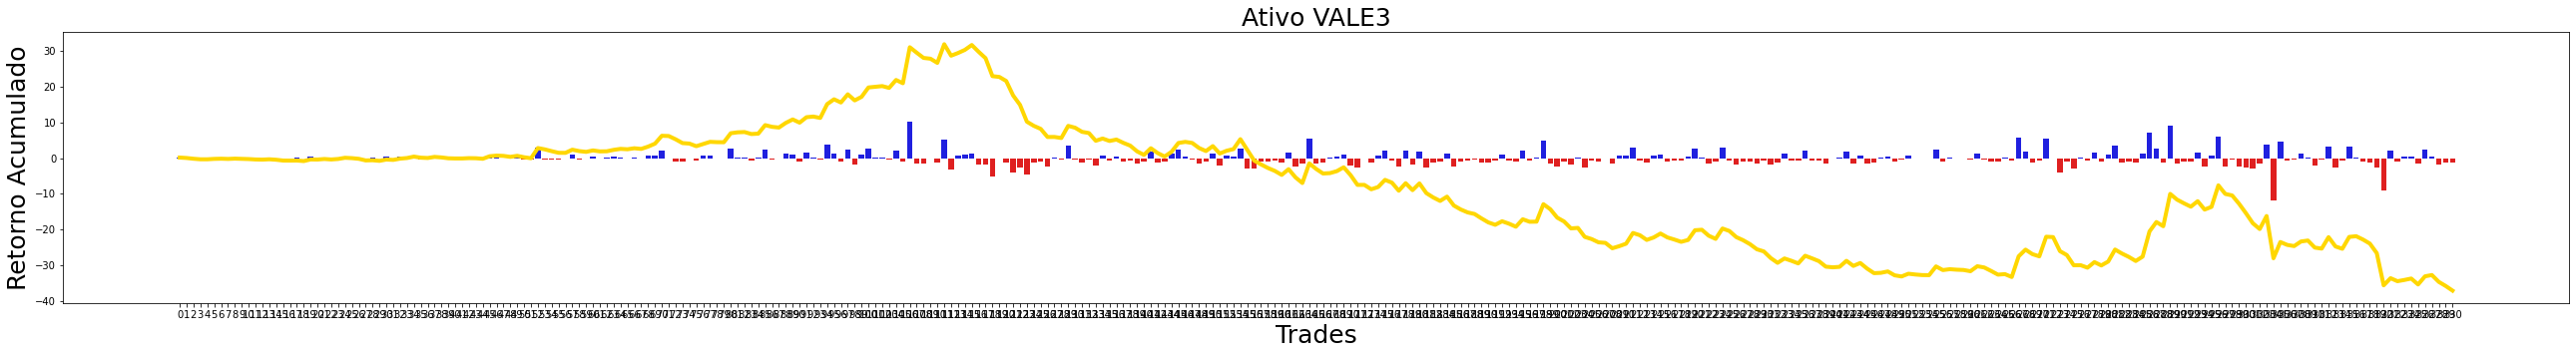

In [9]:
fig, ax = plt.subplots(figsize = (45,5))
clrs = ['red' if (x < 0) else 'blue' for x in gains]
fig = sns.barplot(x = list(range(len(gains))), y = gains, estimator = sum, ci = None, ax=ax,palette=clrs)
ax.plot(np.cumsum(gains),'gold',linewidth=4)
plt.ylabel('Retorno Acumulado',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Ativo '+stocks[n],fontsize=25)
gainsbase=gains.copy()

In [10]:
print("Taxa de Acerto",round(100*(np.sum(np.array(gains)>0)/len(gains)),2),"%")
print("Payoff",round((np.sum(np.array(gains))/len(gains)),2), " R[$]")
print("Retorno",round((np.sum(np.array(gains))),2), " R[$]")
print("Ação Inicial",round(buy_closebuy[0],2), " R[$]")
print("Tempo Posicionado",round(100*np.sum(signals['signal_buy']==1)/signals['signal_buy'].count(),2), "%")

Taxa de Acerto 38.67 %
Payoff -0.11  R[$]
Retorno -37.17  R[$]
Ação Inicial 2.78  R[$]
Tempo Posicionado 54.51 %


Text(0.5, 0, 'Periodo')

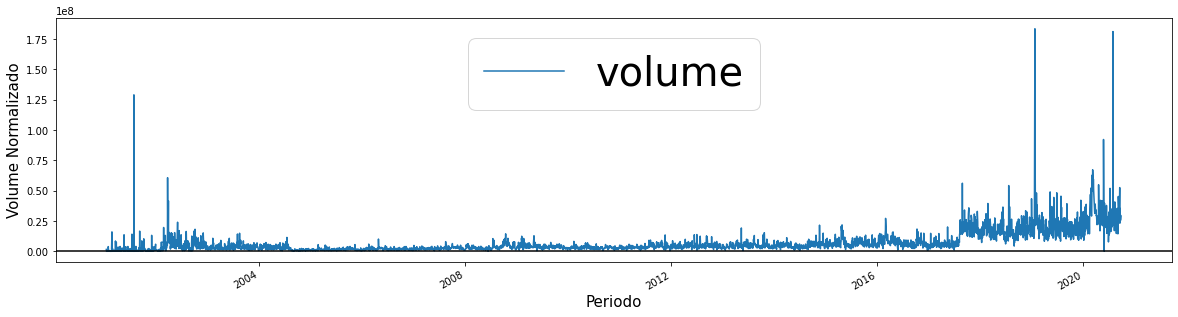

In [11]:
fig, ax = plt.subplots(figsize=(20,5))
signals[['volume']].plot(ax=ax)
ax.axhline(y=0, color='k')
plt.legend(loc=0,prop={'size':40})
plt.ylabel('Volume Normalizado',fontsize=15)
plt.xlabel('Periodo',fontsize=15)
#plt.title('Volume '+ativo,fontsize=15)

## 5) Identificação dos Trades Vencedores

In [12]:
posgains=np.where(np.array(gains)>=0)[0]
possignalbuy=np.where(signals['signal_buy'].diff()==1)[0]
possignalsell=np.where(signals['signal_buy'].diff()==-1)[0]
print(possignalbuy[posgains])
print(possignalsell[posgains])

[   6   60   67   88  130  183  230  253  300  319  331  388  405  435
  452  464  503  573  577  609  636  672  712  824  864  888  902  920
  946  970  992 1013 1106 1120 1151 1187 1203 1222 1233 1283 1305 1347
 1373 1417 1453 1487 1523 1540 1561 1581 1603 1638 1742 1780 1796 1804
 1959 1988 2036 2053 2105 2142 2162 2180 2216 2246 2257 2268 2353 2393
 2442 2446 2467 2518 2560 2583 2628 2669 2727 2822 2887 2921 2938 3024
 3088 3090 3109 3157 3170 3228 3262 3292 3326 3479 3532 3598 3620 3645
 3692 3700 3726 3768 3805 3842 3883 3901 3924 3955 4041 4069 4092 4109
 4171 4186 4223 4258 4337 4357 4372 4444 4472 4539 4552 4607 4666 4698
 4749 4777 4792 4817 4833]
[  16   66   86  105  138  194  238  280  310  329  347  394  424  446
  463  477  516  575  587  633  646  687  740  840  874  896  919  929
  957  985 1004 1030 1118 1141 1173 1198 1211 1230 1249 1301 1322 1360
 1383 1449 1474 1506 1538 1557 1569 1587 1617 1668 1764 1792 1802 1820
 1968 2002 2047 2061 2124 2159 2176 2188 2232 2254

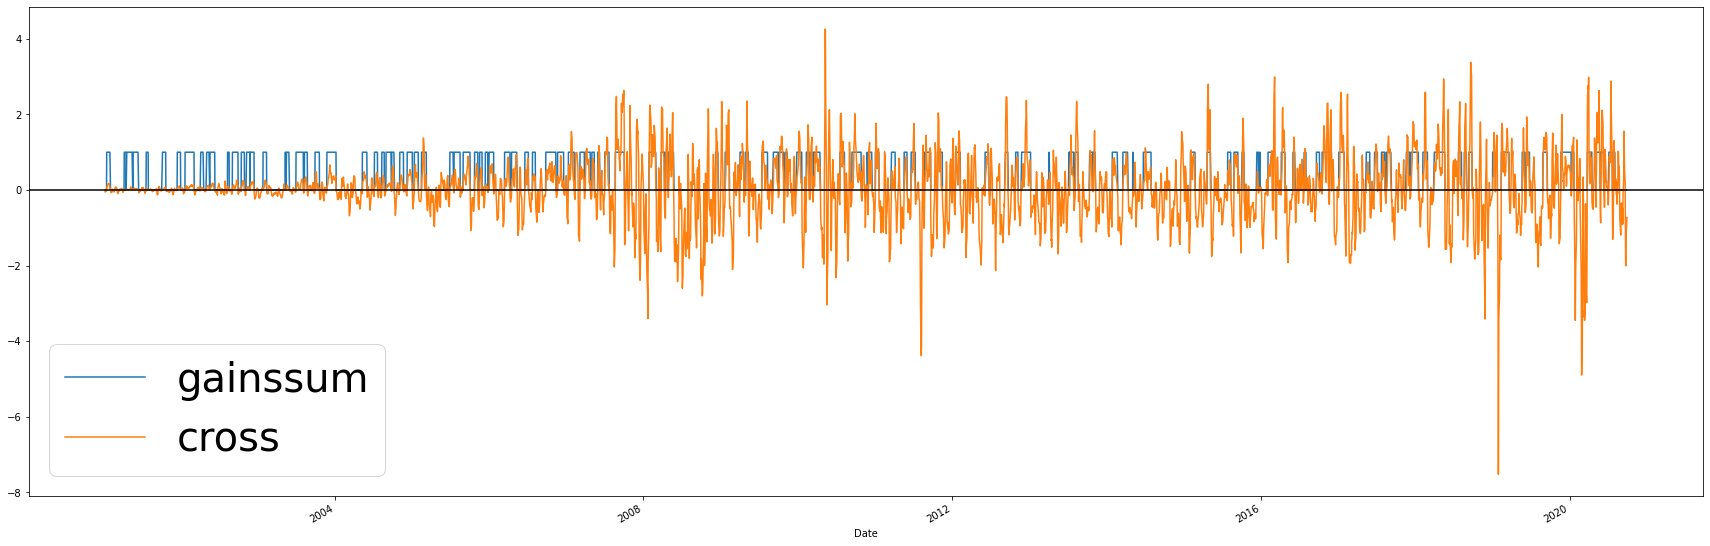

In [13]:
signals['gains'] = 0.0
signals['gains'].iloc[possignalbuy[posgains]]=1
signals['gains'].iloc[possignalsell[posgains]]=-1
signals['gainssum']=signals['gains'].cumsum()
%matplotlib inline
#plt.plot(signals['signal'])
fig, ax = plt.subplots(figsize=(30,10))
signals[['gainssum','cross']].plot(ax=ax)
ax.axhline(y=0, color='k')
plt.legend(loc=0,prop={'size':40})

In [14]:
gains=0
closebuy=signals["close"][signals['gainssum'].diff()==1].values
closesell=signals["close"][signals['gainssum'].diff()==-1].values
gains=[(closesell[i]-closebuy[i]) for i in range(len(closebuy))]
np.asarray(gains)

array([1.40e-01, 0.00e+00, 1.10e-01, 5.00e-02, 8.00e-02, 9.00e-02,
       2.00e-02, 4.50e-01, 1.50e-01, 1.40e-01, 3.30e-01, 5.00e-02,
       3.70e-01, 3.50e-01, 1.70e-01, 4.00e-01, 3.10e-01, 0.00e+00,
       9.00e-02, 7.10e-01, 1.80e-01, 2.90e-01, 2.86e+00, 8.90e-01,
       4.00e-01, 3.00e-02, 4.00e-01, 2.80e-01, 2.80e-01, 6.40e-01,
       8.30e-01, 2.21e+00, 6.00e-01, 6.20e-01, 2.52e+00, 2.60e-01,
       8.00e-02, 1.10e-01, 2.39e+00, 1.31e+00, 9.60e-01, 1.53e+00,
       1.80e-01, 3.87e+00, 1.36e+00, 2.30e+00, 1.00e+00, 2.63e+00,
       1.80e-01, 2.00e-01, 2.23e+00, 1.01e+01, 5.23e+00, 7.50e-01,
       8.80e-01, 1.36e+00, 1.00e-02, 3.41e+00, 6.30e-01, 4.00e-01,
       1.86e+00, 1.33e+00, 2.47e+00, 3.10e-01, 1.38e+00, 7.80e-01,
       4.70e-01, 2.78e+00, 1.60e+00, 5.51e+00, 1.10e-01, 5.50e-01,
       1.08e+00, 0.00e+00, 6.30e-01, 2.01e+00, 2.10e+00, 1.88e+00,
       1.20e+00, 9.90e-01, 2.09e+00, 3.00e-02, 4.90e+00, 1.40e-01,
       5.80e-01, 7.00e-01, 3.01e+00, 6.80e-01, 1.11e+00, 5.20e

In [15]:
signals['class']=signals['gainssum']
signals['class'][signals['gainssum']==1]='buy'
signals['class'][signals['gainssum']!=1]='stop'
signals.tail(60)

,signal_buy,desvio,close,high,low,open,volume,short_mavg,long_mavg,cross,true_range,atr,rsi_u,rsi_d,rsi,gains,gainssum,class
Date,,,,,,,,,,,,,,,,,,
2020-07-06,1.0,0.705715,56.37,56.98,56.10,56.74,13457700.0,56.066667,55.711111,0.355556,0.88,1.496247,0.17,0.00,0.974458,0.0,1.0,buy
2020-07-07,1.0,0.500833,57.32,57.72,55.79,56.90,32545700.0,56.753333,55.857778,0.895556,1.93,1.525164,1.15,0.00,0.975256,0.0,1.0,buy
2020-07-08,1.0,0.534634,56.42,57.68,56.06,57.52,19622600.0,56.703333,55.946667,0.756667,1.62,1.531487,1.25,0.00,0.976126,0.0,1.0,buy
2020-07-09,1.0,0.453689,56.97,57.30,56.16,56.52,14667100.0,56.903333,56.095556,0.807778,1.14,1.505388,1.97,0.00,0.977463,0.0,1.0,buy
2020-07-12,1.0,0.616144,57.65,59.22,57.65,57.73,28534100.0,57.013333,56.287778,0.725556,2.25,1.555028,2.06,0.00,0.978794,0.0,1.0,buy
2020-07-13,1.0,2.557271,61.70,61.97,57.90,57.92,51948600.0,58.773333,57.083333,1.690000,4.32,1.739360,6.31,0.00,0.982237,0.0,1.0,buy
2020-07-14,1.0,2.364678,61.79,62.93,60.39,62.30,29776500.0,60.380000,57.783333,2.596667,2.54,1.792736,5.79,0.00,0.984682,0.0,1.0,buy
2020-07-15,1.0,0.939273,60.12,61.69,59.85,61.30,22591200.0,61.203333,58.323333,2.880000,1.94,1.802553,4.50,0.00,0.986257,0.0,1.0,buy
2020-07-16,1.0,0.836441,61.04,61.25,60.32,60.50,18816000.0,60.983333,58.820000,2.163333,1.13,1.757717,5.41,0.00,0.987864,0.0,1.0,buy


## 6) Concepção da Base de Treinamento e Teste

In [16]:
#my_data=signals[['cross','desvio','rsi','atr','volume','class']]
#X = my_data[['cross','desvio','rsi','atr','volume']].values

my_data=signals[['cross','atr','volume','class']]
X = my_data[['cross','atr','volume']].values
y = my_data['class'].values
print(X[0:15])
print()
print(y[0:15])

[[-4.77777778e-02  7.44052099e-02  1.57140200e+06]
 [-3.33333333e-02  7.19710904e-02  1.57608000e+05]
 [-3.00000000e-02  7.37116890e-02  7.73640000e+04]
 [-4.22222222e-02  7.24263009e-02  1.08000000e+04]
 [-2.88888889e-02  6.85539443e-02  3.60000000e+03]
 [-5.55555556e-03  7.31367919e-02  3.54384000e+05]
 [ 3.77777778e-02  7.98337112e-02  2.08800000e+05]
 [ 8.77777778e-02  7.72864857e-02  1.59192000e+05]
 [ 1.36666667e-01  7.83520346e-02  5.45113000e+05]
 [ 1.53333333e-01  8.67277774e-02  3.91205200e+06]
 [ 1.65555556e-01  8.05033736e-02  1.12320000e+05]
 [ 1.72222222e-01  8.12627919e-02  2.34144000e+05]
 [ 1.48888889e-01  8.19523107e-02  4.88520000e+05]
 [ 1.35555556e-01  8.02408555e-02  6.40801000e+05]
 [ 8.55555556e-02  7.86804554e-02  1.80576000e+05]]

['stop' 'stop' 'stop' 'stop' 'stop' 'stop' 'buy' 'buy' 'buy' 'buy' 'buy'
 'buy' 'buy' 'buy' 'buy']


In [17]:
from sklearn.model_selection import train_test_split
#X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2)#, random_state=3)
X_trainset=X[:int(0.8*len(X))]
X_testset=X[int(0.8*len(X)):]
y_trainset=y[:int(0.8*len(X))]
y_testset=y[int(0.8*len(X)):]

print("shape X_trainset = ", X_trainset.shape)
print("shape y_trainset = ", y_trainset.shape)
print("shape X_testset = ", X_testset.shape)
print("shape y_testset = ", y_testset.shape)   

shape X_trainset =  (3902, 3)
shape y_trainset =  (3902,)
shape X_testset =  (976, 3)
shape y_testset =  (976,)


## 7) Modelagem com Decision Tree e Random Forest

In [18]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
print(DT) # it shows the default parameters

DT.fit(X_trainset,y_trainset)
y_predDT = DT.predict(X_testset)

print("Base de Teste:")
print (y_testset [0:20])
print()
print("Resultado da Predição DecisionTreeClassifier:")
print (y_predDT [0:20])

from sklearn import metrics
print()
print("DecisionTree's Accuracy: ", str(round(100*metrics.accuracy_score(y_testset, y_predDT),2))+"2%")
print()
error=100*np.sum(y_predDT!=y_testset)/len(y_testset)
print("Incorrect Prediction = %.3f" % error, '%')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Base de Teste:
['buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy'
 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy']

Resultado da Predição DecisionTreeClassifier:
['buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'stop'
 'stop' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy']

DecisionTree's Accuracy:  81.762%

Incorrect Prediction = 18.238 %


In [19]:
np.sum(y_testset==y_predDT)/(np.sum(y_testset==y_predDT)+np.sum(y_testset!=y_predDT))

0.8176229508196722

In [20]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(n_estimators=10000,criterion='entropy')
print(RF) # it shows the default parameters

RF.fit(X_trainset,y_trainset)
y_predRF=RF.predict(X_testset)

print("Base de Teste:")
print (y_testset [0:20])
print()
print("Resultado da Predição RandomForestClassifier:")
print (y_predRF [0:20])
from sklearn import metrics
print()
print("RandomForest's Accuracy: ", str(round(100*metrics.accuracy_score(y_testset, y_predRF),2))+"2%")
print()
error=100*np.sum(y_predRF!=y_testset)/len(y_testset)
print("Incorrect Prediction = %.3f" % error, '%')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Base de Teste:
['buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy'
 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy']

Resultado da Predição RandomForestClassifier:
['stop' 'stop' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy'
 'stop' 'buy' 'buy' 'buy' 'buy' 'buy' 'buy' 'stop']

RandomForest's Accuracy:  76.232%

Incorrect Prediction = 23.770 %


## 8) Apresentação do Resultados

In [21]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

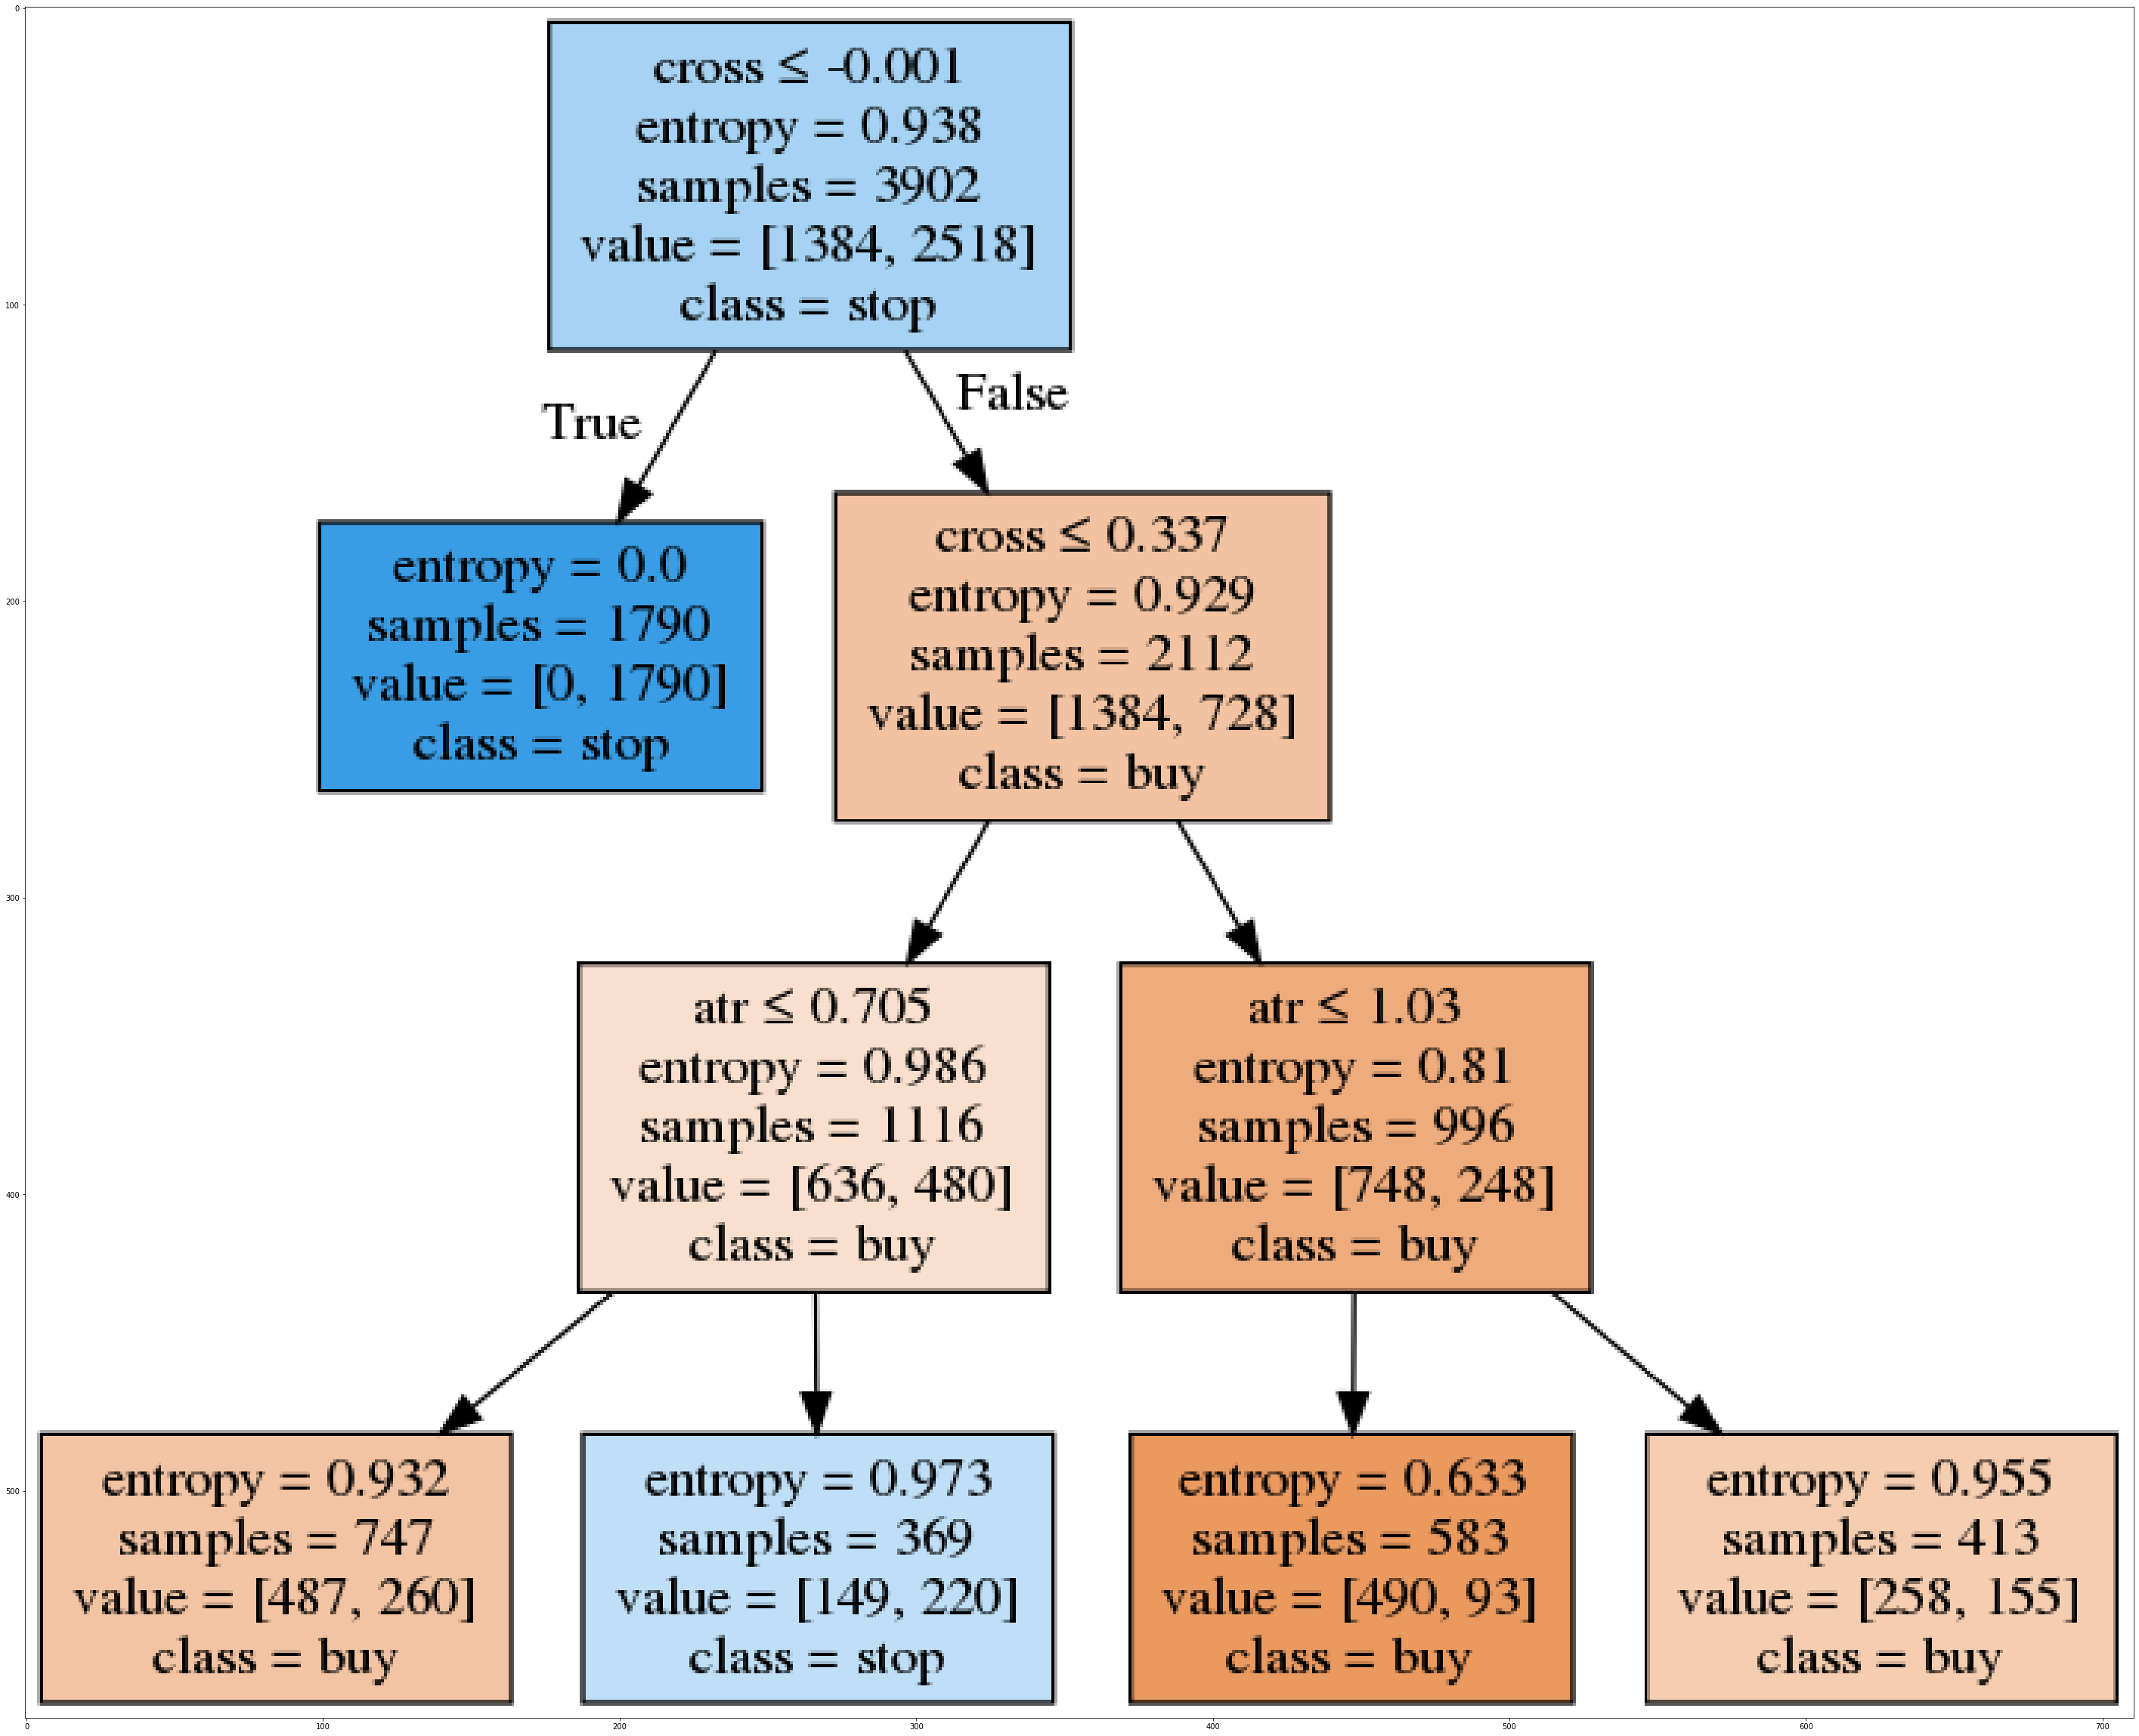

In [22]:
dot_data = StringIO()
filename = "dt_cross.png"
featureNames = my_data.columns[0:my_data.shape[1]-1]
targetNames = my_data["class"].unique().tolist()
out=tree.export_graphviz(DT,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(50, 50))
plt.imshow(img,interpolation='nearest')

In [23]:
#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),fontsize=30,
                 verticalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9    

DecisionTreeClassifier
              precision    recall  f1-score   support

         buy       0.73      0.82      0.77       370
        stop       0.88      0.81      0.85       606

    accuracy                           0.82       976
   macro avg       0.81      0.82      0.81       976
weighted avg       0.83      0.82      0.82       976

Confusion matrix, without normalization
[[305  65]
 [113 493]]


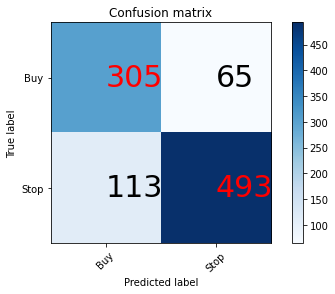

In [24]:
# Compute confusion matrix
print("DecisionTreeClassifier")
cnf_matrix = confusion_matrix(list(y_testset), list(y_predDT))
np.set_printoptions(precision=2)
cnf_matrix
print (classification_report(list(y_testset), list(y_predDT)))

# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Buy','Stop'],
                      normalize= False,  title='Confusion matrix')

RandomForestClassifier
              precision    recall  f1-score   support

         buy       0.76      0.55      0.64       370
        stop       0.76      0.89      0.82       606

    accuracy                           0.76       976
   macro avg       0.76      0.72      0.73       976
weighted avg       0.76      0.76      0.75       976

Confusion matrix, without normalization
[[204 166]
 [ 66 540]]


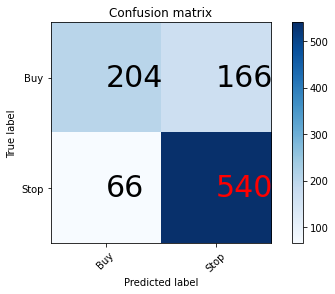

In [25]:
# Compute confusion matrix
print("RandomForestClassifier")
cnf_matrix = confusion_matrix(list(y_testset), list(y_predRF))
np.set_printoptions(precision=2)
cnf_matrix
print (classification_report(list(y_testset), list(y_predRF)))

# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Buy','Stop'],
                      normalize= False,  title='Confusion matrix')

,y_testset,y_predDT,y_predRF
0,1,1,0
1,1,1,0
2,1,1,1
3,1,1,1
4,1,1,1


<AxesSubplot:>

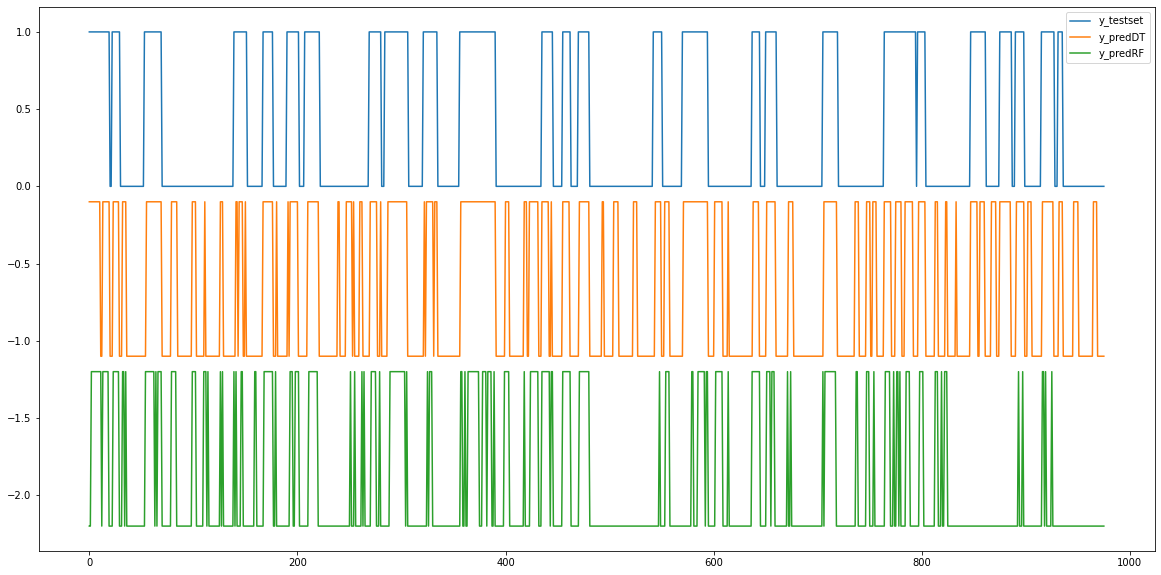

In [26]:
results=pd.DataFrame(index=range(len(y_testset)))
results["y_testset"]=y_testset
results["y_predDT"]=y_predDT
results["y_predRF"]=y_predRF
results.replace(["buy","stop"],[1,0],inplace=True)
display(results.head())
results["y_predDT"]=results["y_predDT"]-1.1
results["y_predRF"]=results["y_predRF"]-2.2
results.plot(figsize=(20, 10))

In [27]:
results["Close"]=data["Close"].iloc[-len(y_testset):].values
results.head()

,y_testset,y_predDT,y_predRF,Close
0,1,-0.1,-2.2,18.62
1,1,-0.1,-2.2,19.10
2,1,-0.1,-1.2,19.91
3,1,-0.1,-1.2,20.30
4,1,-0.1,-1.2,21.35


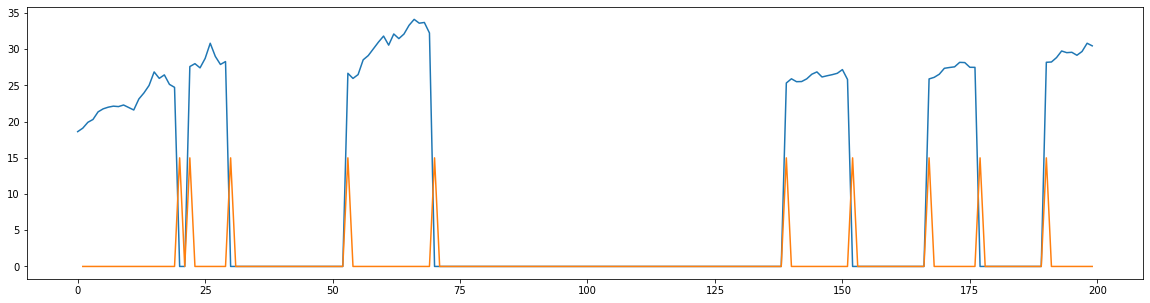

In [28]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(results["Close"].iloc[:200]*results["y_testset"].iloc[:200])
plt.plot(15*np.abs(results["y_testset"].iloc[:200].diff()))

In [29]:
def max_dd(trades):
    """Assumes returns is a pandas Series"""
    xs = trades.cumsum()
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    return xs[j]-xs[i],j,i

def plot_result(results,test):
    posbuy=np.where(np.diff(results[test])==1)[0]+1
    possell=np.where(np.diff(results[test])==-1)[0]+1
    closebuy=results["Close"].iloc[posbuy].values
    closesell=results["Close"].iloc[possell].values
    if possell[0]<posbuy[0]:
        gains=closesell[1:]-closebuy
    else:
        gains=closesell-closebuy       
    print("Taxa de Acerto",round(100*(np.sum(np.array(gains)>0)/len(gains)),2),"%")
    print("Payoff",round((np.sum(np.array(gains))/len(gains)),2), " R[$]")
    print("Retorno",round((np.sum(np.array(gains))),2), " R[$]")
    try: 
        print("Máximo Drawdown",round(max_dd(gains)[0],2), " R[$]")
        print("Retorno/MaxDrawdown",round(np.sum(np.array(gains))/max_dd(gains)[0],2))
    except:
        print("Máximo Drawdown",0, " R[$]")
    print("Ação Inicial",round(buy_closebuy[0],2), " R[$]")
    print()
    fig, ax = plt.subplots(figsize = (20,4))
    clrs = ['red' if (x < 0) else 'blue' for x in gains]
    fig = sns.barplot(x = list(range(len(gains))), y = gains, estimator = sum, ci = None, ax=ax,palette=clrs)
    ax.plot(np.cumsum(gains),'gold',linewidth=4)
    plt.ylabel('Retorno Acumulado',fontsize=25)
    plt.xlabel('Trades',fontsize=25)
    plt.title(test+' Ativo '+stocks[n],fontsize=25)  
    return gains


Taxa de Acerto 100.0 %
Payoff 2.55  R[$]
Retorno 63.66  R[$]
Máximo Drawdown 0  R[$]
Ação Inicial 2.78  R[$]

Taxa de Acerto 42.42 %
Payoff -0.27  R[$]
Retorno -18.02  R[$]
Máximo Drawdown 32.44  R[$]
Retorno/MaxDrawdown -0.56
Ação Inicial 2.78  R[$]

Taxa de Acerto 54.55 %
Payoff 0.13  R[$]
Retorno 10.23  R[$]
Máximo Drawdown 13.0  R[$]
Retorno/MaxDrawdown 0.79
Ação Inicial 2.78  R[$]



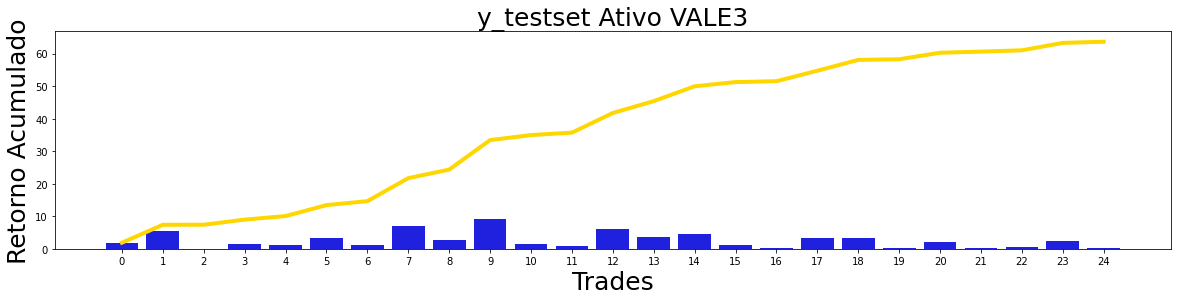

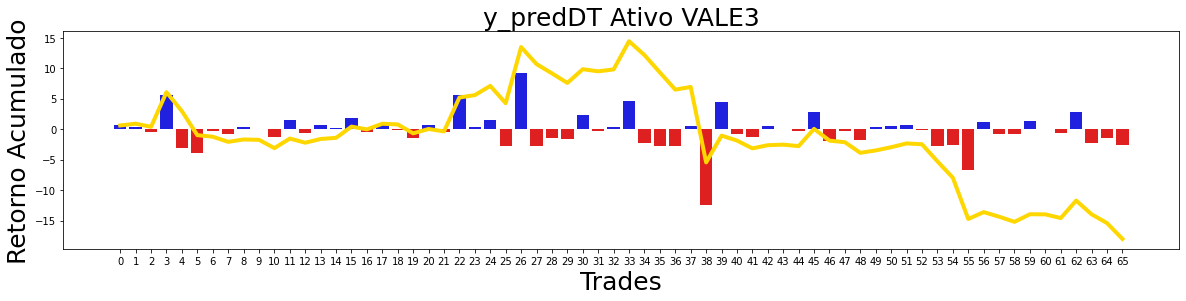

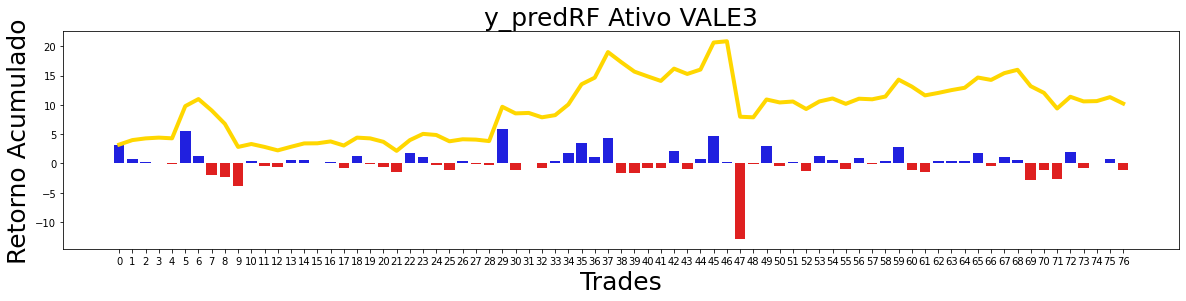

In [30]:
gains1=plot_result(results,'y_testset')
gains2=plot_result(results,'y_predDT')
gains3=plot_result(results,'y_predRF')

Taxa de Acerto 39.68 %
Payoff -0.15  R[$]
Retorno -9.62  R[$]
Máximo Drawdown 29.52  R[$]
Retorno/MaxDrawdown -0.33
Ação Inicial 2.78  R[$]



Text(0.5, 1.0, 'Original Ativo VALE3')

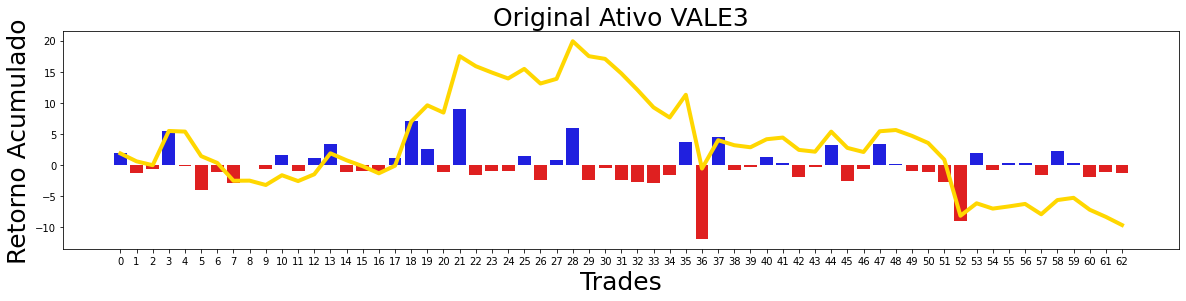

In [31]:
pos_ori=np.min(np.where(np.where(signals['signal_buy'].diff()==1)[0]>(len(signals)-len(y_testset))))
gains=gainsbase[pos_ori:]
print("Taxa de Acerto",round(100*(np.sum(np.array(gains)>0)/len(gains)),2),"%")
print("Payoff",round((np.sum(np.array(gains))/len(gains)),2), " R[$]")
print("Retorno",round((np.sum(np.array(gains))),2), " R[$]")
try: 
    print("Máximo Drawdown",round(max_dd(gains)[0],2), " R[$]")
    print("Retorno/MaxDrawdown",round(np.sum(np.array(gains))/max_dd(gains)[0],2))
except:
    print("Máximo Drawdown",0, " R[$]")
print("Ação Inicial",round(buy_closebuy[0],2), " R[$]")
print()
fig, ax = plt.subplots(figsize = (20,4))
clrs = ['red' if (x < 0) else 'blue' for x in gains]
fig = sns.barplot(x = list(range(len(gains))), y = gains, estimator = sum, ci = None, ax=ax,palette=clrs)
ax.plot(np.cumsum(gains),'gold',linewidth=4)
plt.ylabel('Retorno Acumulado',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title("Original"+' Ativo '+stocks[n],fontsize=25)  


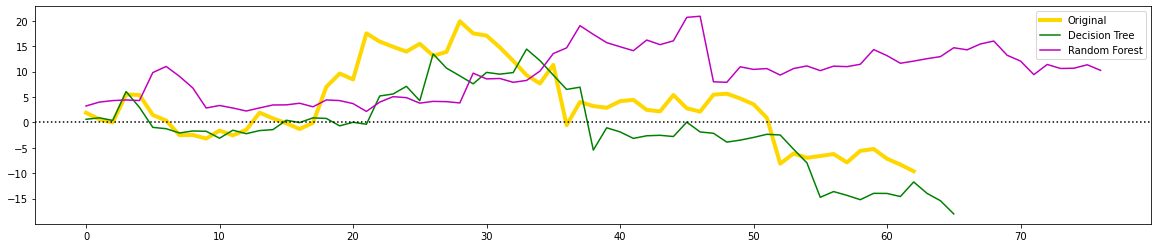

In [32]:
fig, ax = plt.subplots(figsize = (20,4))
plt.plot(np.cumsum(gains),'gold',label="Original",linewidth=4)
plt.plot(np.cumsum(gains2),'g',label="Decision Tree")
plt.plot(np.cumsum(gains3),'m',label="Random Forest")
plt.legend()
plt.axhline(y=0, color='k', linestyle=':')

In [33]:
def result(values):
    x=list(values)
    ddm=max_dd(values)[0]
    sharpe=np.mean(x)/np.std(x)
    gains=[x for x in values if x > 0]
    losses=[x for x in values if x < 0]
    payoff=np.sum(values)/len(x)
    return len(x),ddm, sharpe, payoff, len(gains)/len(losses), 100*len(gains)/len(x), np.sum(np.array(values))

In [34]:
output=[]

for gain in [gains, gains2, gains3]:
    posicoes, ddm, sharpe, payoff, fator_lucro, taxa_ganhos, ganhos = result(gain)
    output.append([posicoes, ddm, sharpe, payoff, fator_lucro, taxa_ganhos, ganhos])


df=pd.DataFrame(output,columns=['Trades', 'MaxDD', 'Sharpe', 'Payoff', 
                             'FL', 'TA', 'Profit']).round(2)
df.index=["Original","Decision Tree","Randon Forest"]
#df.reset_index(inplace=True)
df

,Trades,MaxDD,Sharpe,Payoff,FL,TA,Profit
Original,63,29.52,-0.05,-0.15,0.66,39.68,-9.62
Decision Tree,66,32.44,-0.10,-0.27,0.74,42.42,-18.02
Randon Forest,77,13.00,0.06,0.13,1.20,54.55,10.23


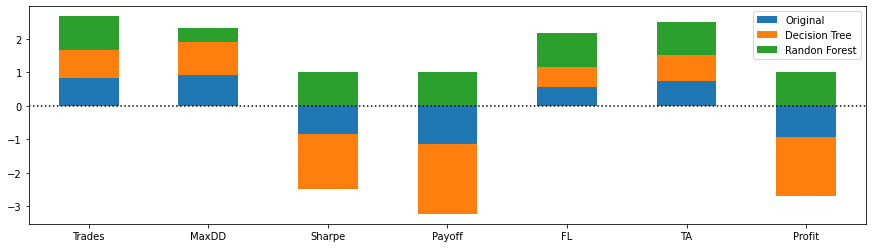

In [35]:
df=df/df.max()
df.transpose().plot(kind='bar', rot=0, stacked=True, figsize = (15,4))
plt.axhline(y=0, color='k', linestyle=':')

<b>Fim da Atividade!!!</b> 
